# Project Group - 15
Members: 

         Guoheng Li 5939259

         Junpeng Li 5921856

         Haosen Luo 5936195
         
         Chenwei Peng 591838


# Contribution Statement

Work in Process

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**: Guoheng Li

**Author 2**: Junpeng Li

**Author 3**: Chenwei Peng

**Author 4**: Haosen Luo


# 1. Introduction



## 1.1 Background



Researching car following models is critical in transportation engineering and urban planning. These models provide insights essential for congestion management, infrastructure planning, environmental impact assessment, and safety improvement. By understanding traffic dynamics, decision-makers can optimize traffic flow, identify congestion-prone areas, and design efficient road networks. This leads to reduced emissions, energy conservation, and increased road safety. Traffic flow models also aid in public transportation optimization, enhancing services for commuters. They support data-driven decision-making and offer economic benefits by improving productivity and reducing fuel consumption. In essence, traffic flow models are invaluable tools that inform decisions, ultimately shaping sustainable urban development and improving overall quality of life.

Based on its importance, a variety of car following models are put forward trying to model such phenomenon. However, different models are based on different assumptions, formulations and methodologies, which entails real-world data to test their limitations and advantages, for instance, some of them can't account for some specific car following patterns. Nowadays, with preprocessed real-world car following data, we are able to calibrate the car following phenomana better and more precisely.

## 1.2 Research Objective



Therefore, in this project the objectives are:

1. Are there correlations among some car following variables(e.g.headway, follower's velocity and acceleration)? How are the Intelligent Driver Model(IDM) and Gipps models formulated?

2. Can IDM and Gipps models be implemented? How to estimate the parameters? Are there some pros and cons between these two models? How to possibly further improve these two models?

# 2. Framework



## 2.1 Data Used



In this project, we used car-following datasets provided in [this paper](https://arxiv.org/pdf/2305.18921.pdf), which is originally collected by autonomous vehicles (AVs) from the open Lyft level-5 dataset to study car-following behavior in mixed traffic flow. The dataset consisted of over 29,000 HV-following-AV (H-A) and 42,000 HV-following-HV (H-H) car-following segments. The dataset includes over 1000 hours of perception and motion data collected over a 4-month period from urban and suburban environments along a fixed route in Palo Alto, California. The dataset comprises approximately 170,000 scenes, with each scene spanning approximately 25 seconds. Each scene includes the movement states of perceived vehicles, cyclists, and pedestrians, as well as the position and orientation of the autonomous vehicle (AV). 

Then, data is processed using a data processing framework that involved several steps. First, CF pairs and their raw trajectories were selected from the unlabelled dataset based on certain rules. Then, the raw data quality was assessed through anomaly analysis. The next step involved enhancing the raw data. For AVs, missing segments were filled and smooth position and speed were estimated. For HVs, missing data around 0-speed points was filled using a jerk-minimization method. Finally, vehicle size processing was performed to split the enhanced dataset into two groups: H-A and H-H.

The result of data processing was an enhanced dataset that had higher quality and covered diverse regimes for calibrating car-following models. The enhanced data showed a reduction in anomalies, particularly in abnormal jerk sign inversion. This processed dataset can be further used for investigating car-following behavior in mixed urban traffic and the impact of AVs on traffic.

With diverse algorithms, we have obtained the data of the regime of each vehicle from an enhanced dataset. In the dataset of regime of each vehicle pairs, we have considered 7 regimes: 
  1. free acceleration (Fa)
  2. free deceleration not caused by the leading vehicle (Fd)
  3. cruising at a desired speed (C)
  4. acceleration following a leading vehicle (A)
  5. deceleration following a leading vehicle (D)
  6. constant speed following (F)
  7. standstill (S)

The dataset also provides the time duration of each regime as well as the combination for each car-following case id which is for further analysis.

**All the steps above are already done before dataset published, thus how to impletement these process is out of scope of our project, our project focuses on visualization, modelling and calibration on car following models, using the processed data**


## 2.2 Data Preprocessing Pipeline

### 2.2.1 Organizing and exporting data
We acquired the data as zarr files. zarr files can be used for large-scale file storage, but are relatively difficult to extract and analyze. After the discussion, we finally decided to use 5000 sets of car_following data for processing and analysis in this project. Firstly, a function is defined to extract the x_lead, v_lead, a_lead, x_follow, v_follow, a_follow, timestamps (vehicle centroid, speed, acceleration data and time points of the lead and following vehicles respectively) from the trainHA.zarr and trainHH.zarr folder, add the ids and import all the data into a csv file named multi_data.csv. Then, because the size of the vehicle is different in each following model,  the size data of the front and rear vehicles is extracted as size_lead, size_follow and after adding the ids to it, the data is imported into a csv file named multi_size.csv.

### 2.2.2 Data Segmentation and Preprocessing
After obtaining the original data of the car_following model, we pre-process the data for segmentation. Firstly, we extracted the vehicle size and vehicle centroid data (located in multi_size and multi_data respectively) and used them to calculate the distance between two vehicles in the following mode, including the vehicle spacing (the distance between the rear end of the front vehicle and the front end of the rear vehicle) and the space headway (the distance between the front end of the front vehicle and the front end of the rear vehicle), which were calculated by the formulae:
 1. $\text{Vehicle Spacing} = \text{centre point of the lead vehicle} - \text{centre point of the following vehicle} - \frac{1}{2}(\text{length of lead vehicle} + \text{length of following vehicle})$
 2. $\text{Space Headway} = \text{centre point of lead vehicle} - \text{centre point of following vehicle} + \frac{1}{2}(\text{length of lead vehicle} + \text{length of following vehicle})$ 
 3. The two data are named as A_distance and B_distance, and finally they are output as distance.csv file.

### 2.2.3 Export of different following models
In the car_following model, the following states of the vehicle are different at different times, which are classified into 7 types as follows: 
A (acceleration), D (deceleration), F (follow), Fa (free acceleration), Fd (free deceleration), C (cruise), S (standstill). 
In order to explore the relationship between the different following states, we need to extract all the following states and create separate csv files. In regimes_list_HA_train.csv and regimes_list_HH_train.csv, the order and duration of the different following modes are regulated as follows:

| CASE_ID | A | D | F | Fa | regime_combination | C | Fd | S |
|:--------| --|-------|----|--------------------|---|----|---|
| Scene ID for each set of car following data | duration for A regime |duration for D regime| duration for F regime| duration for Fa regime| combination of regimes|

![IMAGE](./images/regime.jpg)

So for preprocessing, we first read the regimes string and identify the different following modes, and then export the vehicle data of different durations in multi_data.csv according to the corresponding durations. Finally, these data are imported into seven different csv files, each named after a different regime.
Finally, since A, D, and F are the classical car following models, according to the conclusion in [2], in order to make use of the data to estimate the parameters in IDM model, each scene of data is required to contain at least A, D, F regimes. Therefore, we use Regular Expression in python to filter out the scenes that contain the three ADF modes and export the data according to the number of scenes other than the ADF and import them into different csv files named ADF+1_multi_data.csv etc., respectively.
After this we perform data visualization.

In the end, the data is organised as follows (due to the file size issue, we can't upload the file to Github repository):


In [ ]:
# ├─HA
# |       A.csv
# |       ADF+1_multi_data.csv
# |       ... (the same directories as in HH directory)
# │   
# │
# └─HH
#         A.csv
#         ADF+1_multi_data.csv
#         ADF+2_multi_data.csv
#         ADF+3_multi_data.csv
#         ADF+4_multi_data.csv
#         ADF_multi_data.csv
#         C.csv
#         D.csv
#         distance.csv
#         F.csv
#         Fa.csv
#         Fd.csv
#         multi_data.csv
#         multi_size.csv
#         regimes_list_HH_train.csv
#         S.csv

## 3 Pipeline

## 2.2 Data



### 2.2.1 Data Processing
We will clean the data, reduce data noise, and improve the quality of the data, making it more suitable for subsequent analysis or modeling tasks.

### 2.2.2 Data Sorting
We will classify the following 7 modes based on size, centroid, acceleration and velocity: free acceleration (Fa), free deceleration not caused by the leading vehicle (Fd), cruising at a desired speed (C), acceleration following a leading vehicle (A), deceleration following a leading vehicle (D), constant speed following (F), and standstill (S).

### 2.3.1 Data Exploration
In order to explore the relations between the given car following dataset and the common car following models, and to derive some inspirations on how these models are developed, we resort to data exploration methods to help analyzing. 

Here are several ways to perform calculations on data：
- Headspace：The distance between the heading of the front car and the rear car.
- Vehicle distance: The distance from the rear bumper of the front vehicle to the front of the rear vehicle.
- Effect of size on distance：Effect of vehicle size on distance between vehicles.
- Statistics: Variance / mean.
- Analyze different regimes: Relationships between vehicle attributes.
By analylising these 



## 2.3 Modelling


We will apply the Intelligent Driver Model and Gipps Model to verify their applications on different regimes, and try analysing their behaviour patterns as well pros and cons. However, to do so there are some parameters left to be filled in. Therefore, we have to calibrate the parameters first objectively and comprehensively, i.e. we decided to calibrate the parameters by using algorithms to minimize the total car following trajectory loss, and apply them to different regimes due to the huge discrepancy among various patterns.


![IMAGE](./images/image.png)

# 3. Data Exploration

In [1]:
# import dependent libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import math


# DIRECTORIES
PROJECT_FILE = "../"
MULTI_SIZE_FILE = PROJECT_FILE + 'data/HH/multi_size.csv' 
MULTI_FILE = PROJECT_FILE + 'data/HH/multi_data.csv' 

# IPYNB CONFIG
%matplotlib inline


## 3.1 Data Description



### 3.1.1 Vehicle Size Distribution Description


**The size of vehicles usually represents some features of a kind of specific vehicle, for instance, the longer vehicle tends to be truck, and thus accelerate at lower rate. Therefore, analysing the distribution of the vehicles type is of great importance in our study.**

1） The Vehicle Length Frequency Distribution chart depicts the frequency distribution of vehicles of different lengths. The vehicle length ranges from 0 meters to approximately 17.5 meters. Most vehicles fall within the range of 2.5 meters to 7.5 meters, with the highest frequency observed between 2.5 meters and 5.0 meters, surpassing 1400 vehicles. This indicates that the majority of vehicles are relatively short, likely small or compact cars.

2）Vehicle Length Category Histogram
Conforming to the conventions, we devide the vehicles into 6 categories by their lengths for further research. This graph illustrates the number of vehicles in different length categories. Among these categories, "Compact (4.4-6)" has the highest count, with a total of 2378 vehicles, while "Mini (3-3.5)" has the fewest, with only 16 vehicles. Compact category vehicles are the most prevalent, while Mini category vehicles are the least common. It is evident that the number of Compact and Small category vehicles significantly exceeds other categories in the dataset under study, indicating that these two vehicle types are the most commonly observed.

3）The pie chart illustrates the proportion of various vehicle sizes among all the vehicles. Among them, the compact vehicles occupy the largest share at 47.9%, while the mini vehicles have the smallest share at 0.3%. This indicates that the dataset primarily consists of compact and small vehicles, which can serve as a reference for the parameters related to vehicle length used in the subsequent traffic model

The data from both charts complement each other, providing a comprehensive view of vehicle lengths and their distribution.

**Conclusion: Even though the dataset covers more compact cars and smalls cars than large cars, which could affect the parameters selection in model (for example, the larger cars has lower expected acceleration). However, we can eliminate the partiality by using different sets of parameters to describe the heterogeneity**

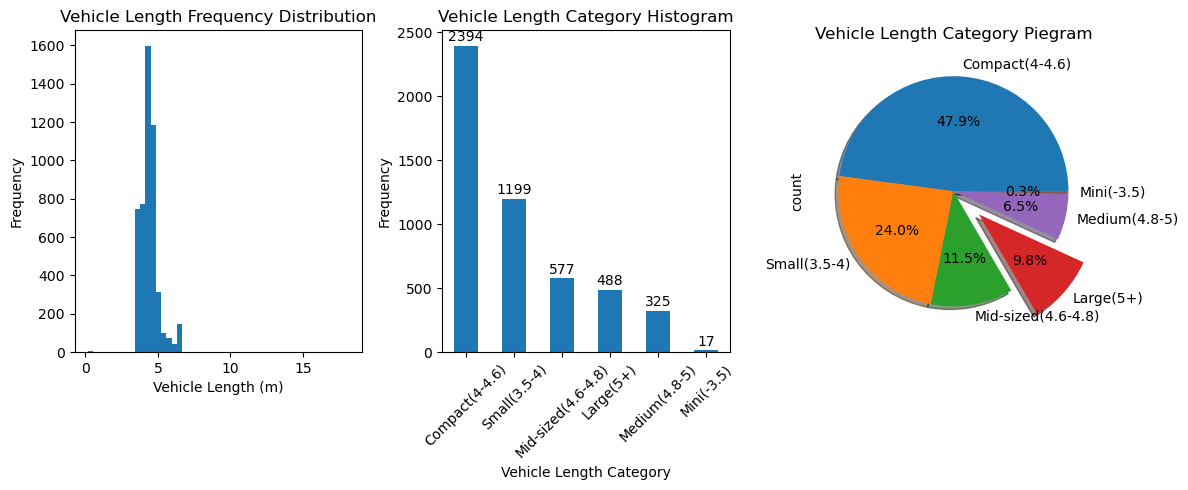

In [2]:
df_multi_size = pd.read_csv(MULTI_SIZE_FILE)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# First subplot - Histogram
axes[0].hist(df_multi_size['size_lead'], bins=50)
axes[0].set_xlabel('Vehicle Length (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Vehicle Length Frequency Distribution')

# Second subplot - Length Category Histogram
bins = [0, 3.5, 4, 4.6, 4.8, 5, max(df_multi_size['size_lead'].values)]
labels = ['Mini(-3.5)', 'Small(3.5-4)', 'Compact(4-4.6)', 'Mid-sized(4.6-4.8)', 'Medium(4.8-5)', 'Large(5+)']
df_multi_size['length_category'] = pd.cut(df_multi_size['size_lead'], bins=bins, labels=labels, right=False)
value_counts = df_multi_size['length_category'].value_counts()

axes[1] = value_counts.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Vehicle Length Category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Vehicle Length Category Histogram')
axes[1].tick_params(axis='x', rotation=45)

explode = [0 ,0, 0, 0.3, 0, 0]
axes[2] = value_counts.plot(kind='pie', explode=explode, ax=axes[2], autopct="%1.1f%%", shadow=True, startangle=0)
axes[2].set_title('Vehicle Length Category Piegram')

# Add specific frequency values on the second subplot
for i, v in enumerate(value_counts):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the entire figure
plt.show()

According to the classification above, and considering the complexity of the categorization, we decide to divide the vehicles into 3 types based on their length. The classification criterior is as follows:

In [2]:
def get_car_type(length):
    
    if 5 < length:
        return "Large"
    if length <= 4.6:
        return "Small"
    if 4.6 < length <= 5:
        return "Medium"
    
    return None

### 3.1.2 Variables in Data

In order to lay an accurate account for the car following data, the velocity $v_\text{lead}$, $v_\text{follow}$, the acceleration $a_\text{lead}$, $a_\text{follow}$, and the distance $s$ between two vehicles are indispensible. Therefore, the distribution and the basic statistics of these data are to be acquired. 


1. Mean, Max, Min: The max of velocities for both cars are low, in terms of the velocity that is usually observed on freeway, which implies that the data is collected from the street in the city, which could also impact the behaviour of driver and the estimation of car following parameters. Especially the mean of acceleration concentrated around 0, but also with many scattered abnormality values (which could be erratum or error).
2. Variance: As is shown in the table and the boxplots below, disregarding the heterogeneity of different types of vehicles, the total distribution of these variables are scattered, which can be shown by the high variance and the long tails of boxplots. But it indeed implies that there could be latent patterns of car following behaviours. 
3. Distance should be of the greatest importance for formulating a car following model, as is shown in the boxplot, there are many outliers in the distance, which could imply that free flow situations exist. And the distribution of the distance is skewed, centered around 20(m), which implies the larger the distance is, the less chances that is going to happen.

,v_follow,v_lead,a_follow,a_lead,distance
count,1006176.00,1006176.00,1006176.00,1006176.00,1006176.00
mean,9.16,9.37,0.15,0.21,24.00
std,6.52,6.66,0.75,0.73,14.68
min,-2.70,-2.57,-8.55,-7.96,0.26
25%,1.89,1.70,-0.17,-0.10,12.27
50%,10.57,11.06,0.03,0.05,20.84
75%,15.09,15.32,0.45,0.48,31.61
max,22.92,24.10,11.24,9.91,84.85


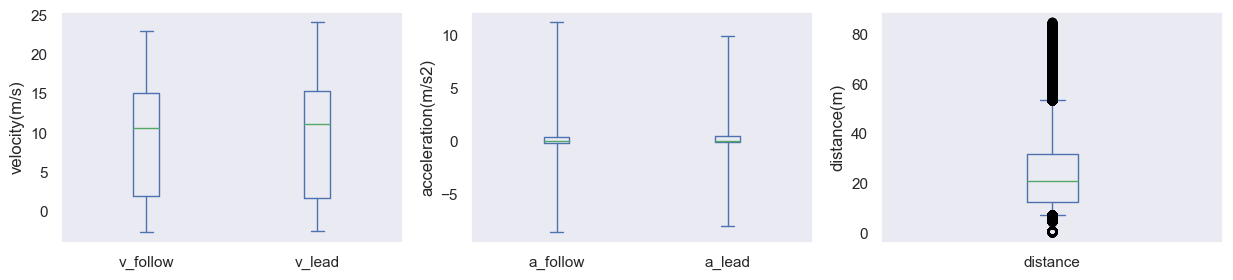

In [51]:
# Define the directory
FOLDER_PATH = PROJECT_FILE + "data/HH"
vars = ["v_lead" , "a_lead", "v_follow", "a_follow"]
vars_label = ["velocity_lead(m/s)", "acceleration_lead(m/s^2)", "velocity_follow(m/s)", "acceleration_follow(m/s^2)"]


# needed data
df_size = pd.read_csv(MULTI_SIZE_FILE)
df = pd.read_csv(MULTI_FILE)

pd.set_option("display.float_format", lambda X: "%.2f" % X)
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

df["distance"] = df["x_lead"] - df["x_follow"]


df[["v_follow", "v_lead"]].plot(kind="box", whis=[0, 100], ax=axs[0], ylabel="velocity(m/s)")
df[["a_follow", "a_lead"]].plot(kind="box", whis=[0, 100], ax=axs[1], ylabel="acceleration(m/s2)")
df["distance"].plot(kind="box", whis=[5, 95], ax=axs[2], ylabel="distance(m)")

df[["v_follow", "v_lead", "a_follow", "a_lead", "distance"]].describe()

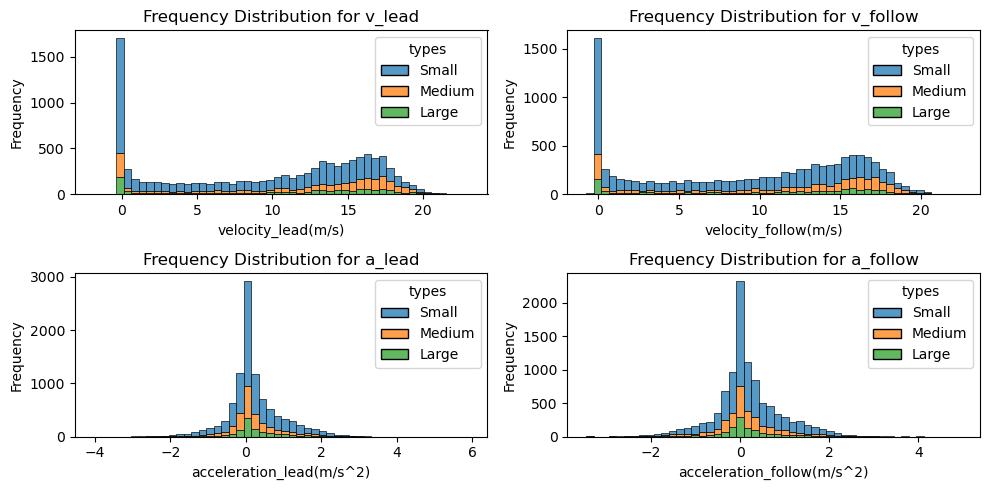

In [17]:
# Create a new plot, with subplots of 2 x 3
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# extract follow acceleration data
follow_acceleration = df.groupby('ID').sample(2, replace=True)
follow_acceleration = follow_acceleration.merge(df_size, on='ID')

follow_acceleration["types"] = follow_acceleration["size_follow"].apply(get_car_type)

# Iterate each csv file
for i, var in enumerate(vars):
    
    # compute row and column index
    row = i % rows
    col = i // rows
    
    # Draw the histograms
    sns.histplot(data=follow_acceleration, x=var, bins=50, ax=axs[row, col], hue="types", multiple="stack")
    axs[row, col].set_xlabel(vars_label[i])
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Frequency Distribution for {var}')


# Remove redundant white subplots
for d in range(i + 1, math.ceil(rows*((len(vars) / rows)))):

    # compute row and column index
    row = d % rows
    col = d // rows

    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()



### 3.1.3 Rationality for Deviding Vehicles into Different Vehicle Types

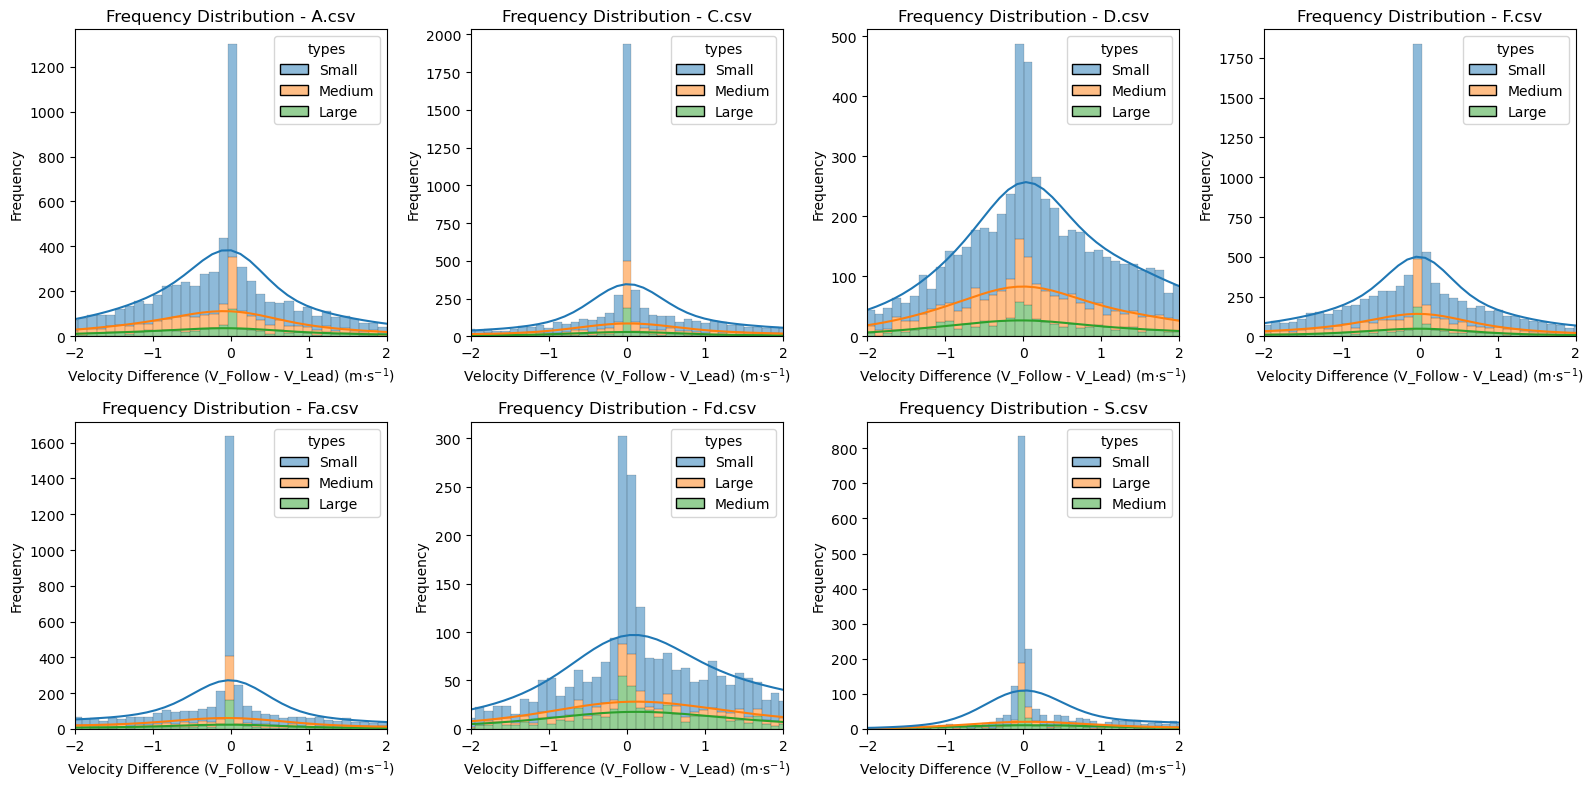

In [12]:
# Define the directory
FOLDER_PATH = PROJECT_FILE + "data/HH"
# csv_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv') and f.startswith("ADF")]
csv_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv') and not f.startswith("ADF") and f[0].isupper()]


def plot_dist(csv_files, var_name, label, rows=2, xlim=None, bins=200):
    cols = math.ceil(len(csv_files) / rows)

    fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
    df_size = pd.read_csv(MULTI_SIZE_FILE)


    # Iterate each csv file
    for i, csv_file in enumerate(csv_files):
        # construct a complete directory
        file_path = os.path.join(FOLDER_PATH, csv_file)
        df = pd.read_csv(file_path)

        df['diff_velo'] = df['v_follow'] - df['v_lead']
        
        # extract follow acceleration data
        follow_acceleration = df.groupby('ID').sample(2, replace=True)
        follow_acceleration = follow_acceleration.merge(df_size, on='ID')

        follow_acceleration["types"] = follow_acceleration["size_follow"].apply(get_car_type)
        
        # compute row and column index
        row = i // cols
        col = i % cols

        
        # Draw the histograms
        sns.histplot(data=follow_acceleration, bins=bins, x=var_name, ax=axs[row, col], hue="types", kde=True, multiple="stack")
        axs[row, col].set_xlabel(label)
        axs[row, col].set_xlim(xlim)
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_title(f'Frequency Distribution - {csv_file}')

    # delete the redundant subplots automatically
    for d in range(i + 1, cols*rows):

        # compute row and column index
        row = d // cols
        col = d % cols

        fig.delaxes(axs[row, col])

    plt.tight_layout()
    plt.show()

plot_dist(csv_files, var_name="diff_velo", label='Velocity Difference (V_Follow - V_Lead) (m$\cdot$s$^{-1}$)', rows=2, xlim=[-2, 2], bins=200)


### 3.1.4 Speed & Acceleration Distribution Histograms for Following Vehicles in Different Modes



In ADF Mode:
This chart displays the speed distribution of vehicles. The distribution forms a distinct bell-shaped curve, concentrated between -0.5 (representing measurement errors) and 0.25 m/s². This indicates that in the basic ADF mode, the variation in vehicle speed acceleration is very small, with most vehicles maintaining a stable speed.

In ADF+1 Mode:
The speed distribution ranges from 0 to 20 m/s. The data distribution is relatively uniform, with no pronounced peaks, but there is a slight elevation between 5 m/s and 7.5 m/s. This suggests that in this mode, vehicle speed selection is relatively balanced, with no specific concentration trend.

In ADF+2 Mode:
The speed distribution also ranges from 0 to 20 m/s. Similarly, there are no very distinct peaks, but the data is slightly concentrated between 5 m/s and 10 m/s. This indicates that in this mode, vehicles tend to travel at moderate speeds.

In ADF+3 Mode:
The speed distribution ranges from 0 to 20 m/s. The data distribution is somewhat scattered, but the speed selection is more concentrated between 5 m/s and 10 m/s. This suggests that in the ADF+3 mode, vehicles also tend to favor moderate speeds.

In ADF+4 Mode:
The speed distribution ranges from 0 to 10 m/s. The distribution in this chart is more scattered, with no clear concentration trend. A possible explanation is that in ADF+4 mode, vehicle speed selection is more flexible and lacks specific preferences.

**Different ADF modes exhibit distinct speed distributions, reflecting varying macroscopic traffic flow characteristics. For example, in the ADF mode, the traffic model may depict that most vehicles on the road maintain relatively stable speeds for the majority of the time. In the ADF mode, the model portrays relatively stable driving behavior. In ADF+1 and ADF+2 modes, vehicles demonstrate smoother acceleration patterns, which are particularly useful for simulating typical traffic conditions, such as congestion analysis during peak hours. This provides valuable guidance for parameter selection in later modeling, enhancing the ability to simulate and understand vehicle behavior and traffic flow in different traffic scenarios.**

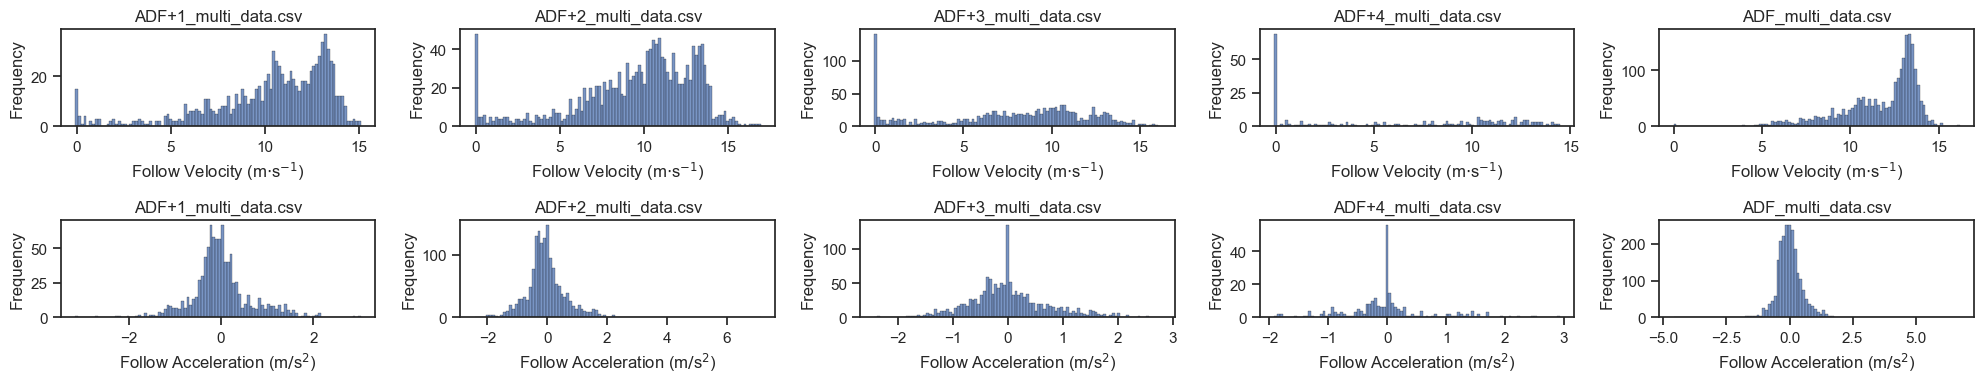

In [66]:
# new directory
DIR = PROJECT_FILE + "/data/HA"
csv_files = [f for f in os.listdir(DIR) if f.endswith('.csv') and f.startswith("ADF")]

fig, axs = plt.subplots(2, 5, figsize=(20, 4))

for i, csv_file in enumerate(csv_files):

    # construct a complete directory
    file_path = os.path.join(DIR, csv_file)
    df = pd.read_csv(file_path)
    
    # extract data we need and sample to make the number of data entry from each scene is consistent
    data = df.groupby('ID').sample(2)
    
    # calculate index
    row = 0 
    col = i
    
    # plotting
    sns.histplot(data['v_follow'], bins=100, kde=False, edgecolor='black', ax=axs[row, col])
    axs[row, col].set_xlabel('Follow Velocity (m$\cdot$s$^{-1}$)')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'{csv_file}')

    sns.histplot(data['a_follow'], bins=100, kde=False, edgecolor='black', ax=axs[row + 1, col])
    axs[row + 1, col].set_xlabel('Follow Acceleration (m$/$s$^{2}$)')
    axs[row + 1, col].set_ylabel('Frequency')
    axs[row + 1, col].set_title(f'{csv_file}')



plt.tight_layout()
plt.show()

## 3.2 Correlation Analysis


### 3.2.1 Relationship between Following Vehicle Speed and Headway


These charts illustrate the relationship between the headway (gap between vehicles) and the average speed of following vehicles.

This chart displays the relationship between different types of vehicle following distances and the average speeds of trailing vehicles. From the chart, it can be observed that there are the most medium-sized vehicles, and the following speeds are primarily centered around 16 m/s, with following distances around 20 meters. The following speeds and following distances for small-sized vehicles exhibit slightly smaller variations, indicating a smoother driving pattern. This suggests that the driving behavior of small-sized vehicles is relatively more stable.

For large-sized vehicles, the following speeds are more concentrated around 17 m/s, with a larger proportion of them having following distances below 15 meters. This chart highlights that different vehicle types have distinct habits in terms of following distances and speeds. Furthermore, based on the trends shown in the chart, it can be observed that regardless of the vehicle type, there is a tendency to adopt higher speeds with greater inter-vehicle spacing. This information can serve as a reference for establishing parameters for different vehicle types in future traffic models and provides insights into the relationship between the speeds and following distances of all following vehicles.

**Conclusion: Most data points indicate that as the following distance increases, the speed of following vehicles tends to rise. This suggests that when the current vehicle maintains a greater distance from the preceding one, the following vehicle is more inclined to accelerate. This may be due to the perception of having more reaction time in a larger space, which makes them feel safer. These observations hold significant guidance for subsequent model development, unveiling one of the fundamental decision factors for rear-end acceleration. Models can utilize these findings for more precise predictions of driver behavior, facilitating parameter selection based on different traffic patterns, leading to an improved simulation and understanding of vehicle behavior and traffic flow in various traffic scenarios.**

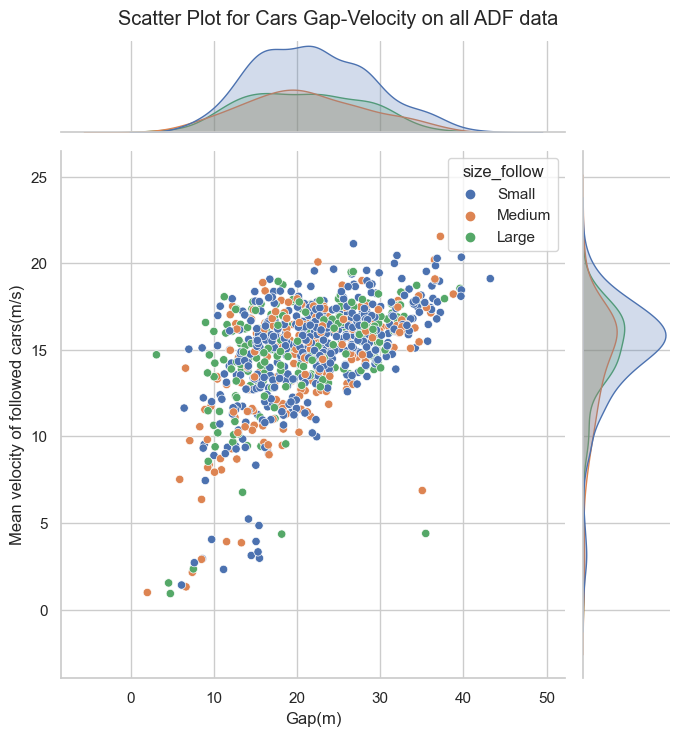

In [71]:
#　define the path
FOLDER_PATH = PROJECT_FILE + "data/HH"
HH_file_path = PROJECT_FILE + 'data/HH/multi_size.csv' 

df2 = pd.read_csv(HH_file_path)  # read the HH file in advance

df1 = pd.read_csv(FOLDER_PATH + '/ADF_multi_data.csv')

df1['x_lead_follow_diff'] = df1['x_lead'] - df1['x_follow']
mean_x_lead_follow_diff = df1.groupby('ID')['x_lead_follow_diff'].mean()

# merge DF1 and DF2, match with the ID key
df_combined = df1.merge(df2, on='ID')
types = df_combined["size_follow"].apply(get_car_type)

# calculate half_size_sum，using size_lead和size_follow
half_size_sum = (df_combined['size_lead'] + df_combined['size_follow']) * 0.5
s = mean_x_lead_follow_diff - half_size_sum

car_0_to_1000 = df_combined
mean_a_follow = df_combined.groupby('ID')['v_follow'].mean()

sns.set(style="whitegrid")
g = sns.jointplot(x=s, y=mean_a_follow, data=car_0_to_1000, kind="scatter", hue=types, height=7)

g.fig.suptitle(f'Scatter Plot for Cars Gap-Velocity on all ADF data', y=1.02)
g.set_axis_labels("Gap(m)", "Mean velocity of followed cars(m/s)")

plt.show()


### 3.2.2 Scatter Plots of Speed and Corresponding Acceleration for Different Vehicles


1. Scatter Heatmap for Lead Cars' Velocity-Acceleration:
This chart illustrates the relationship between the velocity of lead cars (Lead Velocity) and their acceleration (Lead Acceleration). The velocity ranges from 0 to approximately 25, while the acceleration ranges from approximately -7.5 to 10. The densest data points are concentrated in the region of low velocity and acceleration close to 0. This indicates that in such scenarios, most lead cars maintain a steady speed with minimal acceleration or deceleration. As velocity increases, the distribution of acceleration becomes wider, suggesting that at higher speeds, driver reactions and decisions become more varied.

2. Scatter Heatmap for Follow Cars' Velocity-Acceleration:
This chart depicts the relationship between the velocity of follow cars (Follow Velocity) and their acceleration (Follow Acceleration). The velocity range is the same as in the lead cars' chart, while the acceleration range is slightly smaller, ranging from approximately -6 to 8. The data distribution is similar to that of the lead cars' chart, with the densest data points also concentrated in the region of low velocity and acceleration near 0. This suggests that follow cars also tend to maintain a steady speed at these lower velocities. In comparison to lead cars, the acceleration distribution of follow cars at higher speeds is slightly more concentrated, indicating that follow cars exhibit more conservative driving behavior at higher speeds.

Both charts indicate that at lower speeds, most vehicles tend to maintain a steady speed with minimal acceleration or deceleration. Lead cars exhibit a relatively broader acceleration distribution at higher speeds, while follow cars show a more concentrated acceleration distribution at the same speeds. This may reflect the more conservative driving behavior of follow cars when traveling at higher speeds. Overall, both charts demonstrate stability in vehicle behavior at lower speeds and reveal different driving behavior patterns at higher speeds.

**At low speeds, most vehicles exhibit relatively stable speed and acceleration behaviors, whereas at high speeds, differences in behavior between leading and following vehicles may require further explanation in the model. For instance, leading vehicles at high speeds may tend to change their speeds more, while following vehicles may adopt a more conservative approach. This may imply some latent car following behaviour for further formulating car following model**

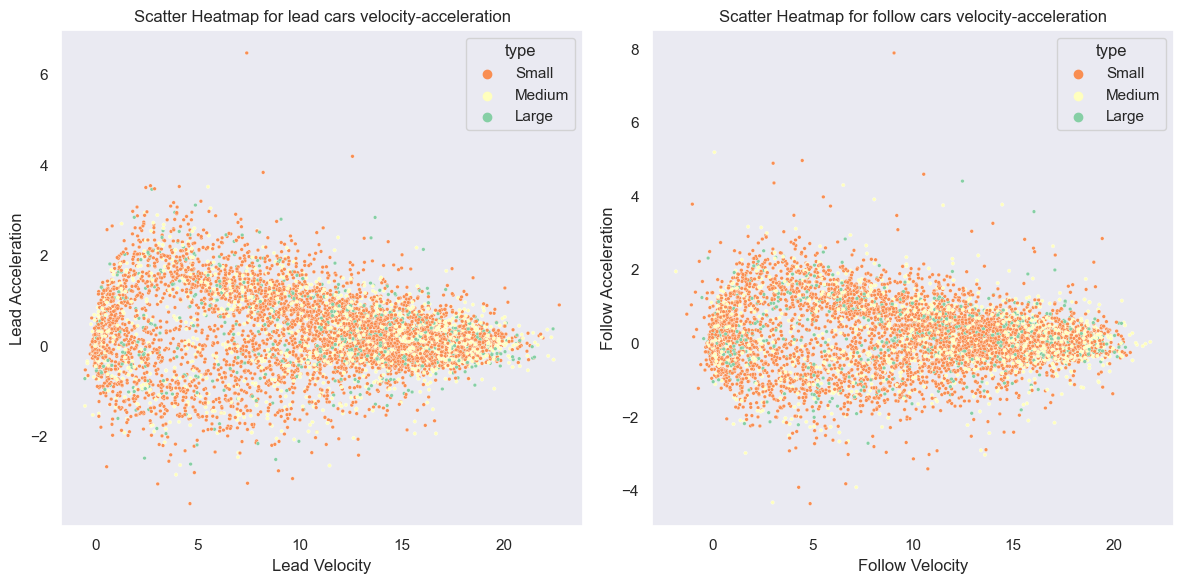

In [50]:
# Read data for both plots
sns.set_theme(style="dark")
file_path = MULTI_FILE
df = pd.read_csv(file_path)
df_size = pd.read_csv(MULTI_SIZE_FILE)

df = df.merge(df_size, on='ID')
df["type"] = df["size_follow"].apply(get_car_type)


df_grouped = df.groupby("ID").sample(2, replace=2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))



# First subplot - Lead Cars
axes[0].set_title('Scatter Heatmap for lead cars velocity-acceleration')
axes[0].set_xlabel('Lead Velocity')
axes[0].set_ylabel('Lead Acceleration')
sns.scatterplot(x=df_grouped['v_lead'], y=df_grouped['a_lead'], s=7, color=".15", ax=axes[0], hue=df_grouped["type"], palette="Spectral")
# sns.kdeplot(x=x_lead, y=y_lead, levels=5, color="w", linewidths=1, ax=axes[0])


# Second subplot - Follow Cars
axes[1].set_title('Scatter Heatmap for follow cars velocity-acceleration')
axes[1].set_xlabel('Follow Velocity')
axes[1].set_ylabel('Follow Acceleration')
sns.scatterplot(x=df_grouped["v_follow"], y=df_grouped["a_follow"], s=7, color=".15", ax=axes[1], hue=df_grouped["type"], palette="Spectral")


# Adjust the spacing between subplots
plt.tight_layout()

# Show the entire figure
plt.show()

## 3.3 Conclusion

- There exists heterogeneity in different driving behaviours, in order to describe these heterogeneity, different parameters sets are applied into models to describe the driving behaviour characteristics of different drivers(for example, how aggressive a driver is.). Thus, the statistics in parameter sets is important for describing the heterogeneity in the dataset. 
- Different extended ADF regimes data exhibit distinct speed distributions, reflecting different macroscopic traffic flow characteristics, which ensures that the diversity of data for parameter estimation in car following models. Moreover, the using ADF regimes data to estimate driving behaviours has been widely accepted. Therefore, the data we decide to use is comprehensive and diverse enough to describe different driving behaviours.
- there are some latent characteristics for different drivers in common, for example, when driving at higher speed, driviers are tend to be less aggressive(i.e. less change in acceleration), and larger the gap between 2 vehicles is, the higher velocity the follower is in order to fill the gap till reaching the rear of the leading vehicle. These 2 observations provide 2 fundamental assumptions to formulate the models below.

# 4. Models, Parameters Estimation & Pros and Cons

## 4.1 Models

### 4.1.1 Desired Measures Models (Intelligent Driver Model)





The model presumes that each driver has a desired velocity, headway, and the drivers try to minimize the gap between the actual value and the desired value, while constrained by a variety of conditions, for instance safety distances. Intelligent Driver Model(IDM) is catagorized in this catagorization:

Drivers try to minimize the following distance, and minimize both the speed difference and desired headway as well. In IDM model:

1. The influence factors include own speed $v$, the bumper-to-bumper gap $s$ to the lead vehicle, and the difference of the speed $\Delta v = v - v_{\text{lead}}$

2. The model only outputs the acceleration $a$ on the following car.

3. The model parameters are driving styles.

The IDM model equations are fomulated as follows:
$$
\begin{aligned}
&\frac{dv}{dt} = a\left[1 - \left(\frac{v}{v_0}\right)^\sigma - \left(\frac{s^*(v, \Delta v)}{s}\right)^2 \right]\\

&s^*(v, \Delta v) = s_0 + \max\left[0, \left(vT+\frac{v\Delta v}{2 \sqrt{ab}}\right)\right]
\end{aligned}
$$

where,
- $\frac{dv}{dt}$ is the acceleration the follower vehicle will achieve in the next timestep.
- $a$ is the desired acceleration.
- $b$ is the desired deceleration.
- $v$ is the velocity of the follower in the current timestep.
- $v_0$ is the desired velocity of the follower.
- $s$ is the front-to-rear gap between 2 vehicles, which can be calculated by $x_\text{lead}(t)-x_\text{follow}(t) - \frac{1}{2}(l_\text{lead} + l_\text{follow})$
- $s^*(v,\Delta v)$ is the desired dynamical gap.


In [4]:
class Car:
    
    def __init__(self, size: float, xs: np.array = [], vs: np.array = [], a_s: np.array = []) -> None:
        self.vs = vs  # a list consist of all velocities in all timesteps.
        self.xs = xs
        self.a_s = a_s
        self.size = size

In [6]:
## IDM models with arbitary parameters

class IDM:
    
    def __init__(self, param: dict) -> None:
        ## dict = {v0, s0, T, a, b}
        self.v0 = param['v0']  # the velocity the vehicle would drive at in free traffic
        self.s0 = param['s0'] # a minimum desired net distance.
        self.T = param['T'] # the minimum possible time to the vehicle in front
        self.a = param['a'] # the maximum vehicle acceleration
        self.b = param['b'] # a positive number (comfortable breaking deceleration)
        self.sigma = 4 # exponent factor, usually set to 4

    def get_desired_s(self, v_this, delta_v_i):
        
        desired_s = v_this * self.T + v_this * delta_v_i / (2 * np.sqrt(self.a * self.b))
        return self.s0 + max(0, desired_s)
    
    def get_new_a(self, v_this, v_front, s_this):
        
        delta_v_i = v_this - v_front
        return self.a * (1 - np.power(v_this / self.v0, self.sigma) 
                            - np.power((self.get_desired_s(v_this, delta_v_i) / s_this), 2))
    
    def update(self, lead_car: Car, this_car: Car, time_step: float):
        """
            
        """
        assert this_car is not None
        
        N = len(lead_car.xs)
        
        for i in range(1, N):
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]
            
            gap_now = lead_s_now - this_s_now - 1/2(lead_car.size + this_car.size)  # the distance is head's distance
            this_v_a = self.get_new_a(this_v_now, lead_v_now, gap_now)
            # update
            if this_v_now + this_v_a * time_step < 0:
                this_car.vs.append(0)
            else:
                this_car.vs.append(this_car.vs[i - 1] + time_step * this_v_a)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step + 1 / 2 * this_v_a * pow(time_step, 2))
            this_car.a_s.append(this_v_a)

### 4.1.2 Gipps' Model

Gipps' model is the most popular safety distance model, which assumes that the speeid is selected by the driver to ensure the safety between two vehicles can be held.
Gipps' model includes two modes of driving: free-flow and CF. The Gipps Model equations are formulated as follows:

$$
V(t+\tau) = \min\left\{
    
    \begin{aligned}
    &V(t) + 2.5a_0\tau(1-V(t)/V^*)(0.025V(t)/V^*)^{1/2}\\
    &b_0\tau + \sqrt{b_0^2 \tau^2 - b_0[2s(t)-V(t)\tau - \frac{V'(t)^2}{b_0}]}
    \end{aligned}
    
    
    \right.
$$

due to the different mechanism under these two models, we apply different symbols and notations to describe them.
in above models:
- $\tau$ is the reacting time. usually is $0.2$(s)
- $a_0$ is the max acceleration that a vehicle can achieve.
- $b_0$ is the min acceleration that a vehicle can achieve.
- $V(t)$ is the velocity of the following vehicle at time $t$.
- $V^*$ is the desired speed that the following vehicle want to achieve (i.e. in free flow mode)
- $s(t)$ is the distance to the rear of the front vehicle $x_\text{lead}(t)-x_\text{follow}(t) - \frac{1}{2}(l_\text{lead} + l_\text{follow})$, due to the $x$ here is the centroid of a vehicle.

In [7]:
## Gipps model

class Gipps:
    
    def __init__(self, param) -> None:
        self.rect_time = param["rect_time"]
        self.max_b = param["max_b"]
        self.max_a = param["max_a"]
        self.v0 = param["v0"]


    def update(self, lead_car: Car, this_car: Car, time_step: float):
        """
        """
        
        N = len(lead_car.xs)
        this_car.a_s = None  # Gipps model doesn't need a for estimating
        
        for i in range(1, N):
            
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]

            gap_now = lead_s_now - this_s_now - 1/2(lead_car.size + this_car.size)

            this_v = min(- self.max_b * self.rect_time + np.sqrt(pow(self.max_b, 2) * pow(self.rect_time, 2) + self.max_b * (2*(gap_now)- self.rect_time * this_v_now + pow(lead_v_now, 2)/self.max_b)),
                        this_v_now + 2.5 * self.max_a * self.rect_time * (1 - this_v_now / self.v0) * pow((0.025 + this_v_now / self.v0), 2))

            this_car.vs.append(this_v)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step)


### 4.1.3 Result


Even though the two models above are formualted in the form of continuous time domain, in order to simulate the car-following models on computer, we have to assume that the domain is discrete.

According to the dataset, the timestep is set to be $0.1$ (s) for each entry of data. Thus, we decide to conform to that convention.

In [ ]:
CARS = np.loadtxt(PROJECT_FILE + "data.csv", delimiter=",")
SIZES = np.loadtxt(PROJECT_FILE + "size.csv", delimiter=",")
test_scenes = []
sizes = []
for i in range(1000):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))
    sizes.append(CARS[np.where(CARS[:, 0] == i), :])


test_scene = test_scenes[31]

print("TOTAL TIME STEP: %d" %test_scene.shape[0] )


car_front = Car(sizes[i][1], test_scene[:, 1], test_scene[:, 3], test_scene[:, 3])

car_follow = Car(sizes[i][2], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])

car_follow_real = Car(sizes[i][2], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])

param = {
    "rect_time": 0.2,
    "max_b": 2,
    "max_a": 2
}

gipps = Gipps(param)

gipps.update(car_front, car_follow, 0.1)

print(car_follow.xs)
print(car_front.xs)
print(car_follow_real.xs)


plt.plot(car_front.xs, label="1")
plt.plot(car_follow.xs, label="2")
plt.plot(car_follow_real.xs[0], label="3")
plt.legend()
plt.show()

## 4.2 Parameter Estimation



After deriving the models, we have to calibrate their parameters with real world data to improve their performance. However, calibrating the parameters with the real-life data is not a easy thing. 

First, Based on the research of Anshuman[2], in order to calibrate the IDM model, the data are required to meet the completeness condition, i.e. one scenario consists of at least A(Acceleration), D(Deceleration) and F(Following) regimes.
Therefore, in the data preprocessing stage, we already split the data into ADF, ADF+1, ADF+2 and ADF+n for further process.

Second, the popular calibration methods is Genetic Algorithms(GA), which is a method for solving optimization problems that is based on natural selection, the process that drives biological evolution. After achieving the optimal value for minimizing the loss function (which we will define later) on the train dataset, it's safe to identify that they are the approximate optimal set of parameters, due to the GA is an evolutionary algorithms, which determines that the solution it provides is local optimal, instead of global optimal.


In [ ]:
## import dependencies

from sko.GA import GA 

# Constant values

NUM_TEST = 100
FILE_DIR = "D:\DATA\TIL6022\data.csv"

In [ ]:
def _single_test(test_scene, model):

    car_front = Car(sizes[i][1], test_scene[:, 1], test_scene[:, 3], test_scene[:, 3])

    car_follow = Car(sizes[i][2], [test_scene[0, 4]], [test_scene[0, 5]], [test_scene[0, 6]])

    car_follow_real = Car(sizes[i][2], [test_scene[:, 4]], [test_scene[:, 5]], [test_scene[:, 6]])

    LENGTH = len(car_front.xs)

    model.update(car_front, car_follow, 0.1)
    
    return np.sqrt(1 / LENGTH * np.sum(np.square([x1 - x2 for x1, x2 in zip(car_follow_real.xs[0], car_follow.xs)])))


def fitness(param_set):
    global CARS, test_scenes

    param = {
                "v0": param_set[0],
                "s0": param_set[1] / 100,
                "T": param_set[2] / 100,
                "a": param_set[3] / 100,
                "b": param_set[4] / 100,
                "sigma": 4
                }

    errors = []
    
    model = ()

    for i in range(NUM_TEST):
        test_scene = test_scenes[i]
        errors.append(_single_test(test_scene, model))

    return np.mean(errors)

In [ ]:


CARS = np.loadtxt(FILE_DIR, delimiter=",")
test_scenes = []
for i in range(NUM_TEST):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))


ga = GA(func=fitness, n_dim=5, size_pop=50, max_iter=20, prob_mut=0.01, lb=[5, 10, 30, 1, 10], ub=[40, 400, 200, 600, 600], precision=1)
result = ga.run()
print(result)

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

## 4.3 Pros and Cons

# 5. Limitations and further research

# References

1. [Large Car-following Data Based on Lyft level-5 Open Dataset: Following Autonomous Vehicles vs. Human-driven Vehicles. Guopeng Li, Yiru Jiao, Victor L. Knoop, Simeon C. Calvert, and J.W.C. van Lint](https://arxiv.org/pdf/2305.18921.pdf)
